In [57]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [59]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

In [60]:
def generate_target(file):
    with open(file) as f:
        data_str = f.read()
        
        boxes = []
        labels = []
        
        for line in data_str.splitlines():
            elements = list(map(int, line.split()))
            labels.append(elements[0])
            boxes.append(elements[1:])

        # labels와 boxes를 텐서로 변환
        labels = torch.as_tensor(labels, dtype=torch.int64)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
    
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):

    img = img.cpu().permute(1,2,0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        elif annotation['labels'][idx] == 2 :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')

        else :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [61]:
generate_target("./train_annotations/maksssksksss0.txt")

{'boxes': tensor([[ 79., 105., 109., 142.],
         [185., 100., 226., 144.],
         [325.,  90., 360., 141.]]),
 'labels': tensor([1, 2, 1])}

이 파일 구조를 정확히 맞추어 주어야 쓸 수 있다.

In [70]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'txt'
        img_path = os.path.join(self.path, file_image)

        if 'val' in self.path:
            label_path = os.path.join("val_annotations_sample/", file_label)
        else:
            label_path = os.path.join("train_annotations_sample/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = MaskDataset(data_transform, 'train_images_sample/')
val_dataset = MaskDataset(data_transform, 'val_images_sample/')

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, collate_fn=collate_fn)

In [71]:
def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [72]:
model = get_model_instance_segmentation(4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

c:\Users\taebin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\taebin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [73]:
num_epochs = 1 #빠른 확인을 위해
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [74]:
##잘돌아가나 확인하기 위함
i=0
for imgs, annotations in train_data_loader:
    i += 1
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(imgs)
    print(annotations)
    if i == 2:
        break

[tensor([[[0.4431, 0.4314, 0.3843,  ..., 0.1569, 0.2824, 0.3373],
         [0.4118, 0.3882, 0.3451,  ..., 0.1529, 0.1882, 0.3098],
         [0.3765, 0.3569, 0.3255,  ..., 0.1490, 0.1216, 0.2784],
         ...,
         [0.3333, 0.3412, 0.3569,  ..., 0.1098, 0.1098, 0.1137],
         [0.3373, 0.3490, 0.3608,  ..., 0.1137, 0.1137, 0.1176],
         [0.3647, 0.3765, 0.3922,  ..., 0.1176, 0.1176, 0.1216]],

        [[0.4353, 0.4235, 0.3765,  ..., 0.2314, 0.3843, 0.4549],
         [0.3922, 0.3804, 0.3373,  ..., 0.2275, 0.2863, 0.4275],
         [0.3608, 0.3412, 0.3098,  ..., 0.2235, 0.2235, 0.3922],
         ...,
         [0.3255, 0.3333, 0.3490,  ..., 0.1059, 0.1059, 0.1098],
         [0.3294, 0.3412, 0.3529,  ..., 0.1098, 0.1098, 0.1137],
         [0.3569, 0.3686, 0.3843,  ..., 0.1137, 0.1137, 0.1176]],

        [[0.4549, 0.4431, 0.3961,  ..., 0.4000, 0.6157, 0.7294],
         [0.4157, 0.3922, 0.3490,  ..., 0.3843, 0.5059, 0.6784],
         [0.3647, 0.3451, 0.3137,  ..., 0.3529, 0.4118, 0

In [86]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    
    train_loss = 0
    val_loss = 0
    
    model.train()
    for imgs, annotations in train_data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        train_loss += losses.item()
    
    # model.eval()
    # with torch.no_grad():  # Disable gradient calculation
    #     for imgs, annotations in val_data_loader:
    #         imgs = list(img.to(device) for img in imgs)
    #         annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
            
    #         loss_dict = model(imgs)  # Get the loss dictionary
            
    #         losses = sum(loss for loss in loss_dict.values())  # Sum the losses
            
    #         val_loss += losses.item()  # Accumulate the validation loss
    
    # Print epoch information
    val_loss = 0
    print(f'Epoch : {epoch+1}, Train Loss : {train_loss/len(train_data_loader)}, Val Loss : {val_loss/len(val_data_loader)}, Time : {time.time() - start:.2f} sec')

----------------------train start--------------------------
Epoch : 1, Train Loss : 0.7478184236420525, Val Loss : 0.0, Time : 362.51 sec


In [88]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold :
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [89]:
with torch.no_grad():
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in val_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}, {'boxes': tensor([[130.8578, 110.9414, 174.7996, 151.9978],
        [220.6446, 103.8339, 251.6212, 137.0385],
        [  4.2517, 105.2360,  21.7319, 126.8060],
        [  0.3143, 100.7969,  19.4540, 122.2859],
        [  1.5590, 111.3793,  19.1637, 122.2402],
        [  7.3694, 107.4096,  18.6678, 123.2125],
        [ 83.5603,  91.7099,  93.0378, 108.4664],
        [ 26.5988,  91.4095,  44.1761, 101.3678],
        [ 28.5272,  91.2460,  46.0866, 109.9967]]), 'labels': tensor([2, 2, 2, 2, 2, 2, 2, 2, 2]), 'scores': tensor([0.7250, 0.7195, 0.6886, 0.6654, 0.6590, 0.5478, 0.5261, 0.5045, 0.5025])}]


Target :  tensor([1, 1, 1, 2, 2, 1, 1, 1])


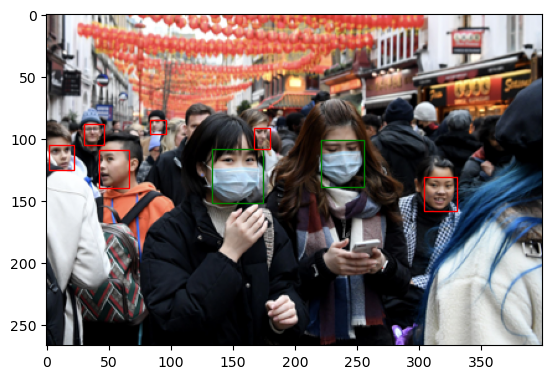

Prediction :  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2])


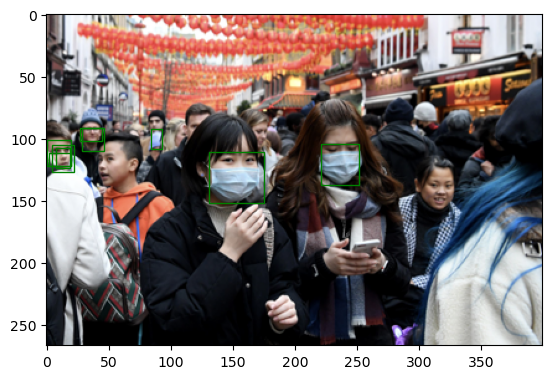

In [91]:
_idx = 1

# Print target labels
print("Target : ", annotations[_idx]['labels'])

# Plot the image with target annotations
plot_image_from_output(imgs[_idx], annotations[_idx])

# Print prediction labels and move tensors to CPU in one line
print("Prediction : ", pred[_idx]['labels'].cpu())

# Plot the image with prediction annotations
plot_image_from_output(imgs[_idx], {
    'labels': pred[_idx]['labels'].cpu(),
    'boxes': pred[_idx]['boxes'].cpu(),
    'scores': pred[_idx]['scores'].cpu()
})